In [1]:
%load_ext autoreload
%autoreload 2

In [30]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import datetime

import sys
sys.path.append("../")

from quotaclimat.data_processing.read_format_deduplicate import read_and_format_one
from quotaclimat.data_processing.read_format_deduplicate import read_and_format_all_data_dump
from quotaclimat.data_processing.read_format_deduplicate import deduplicate_extracts
from quotaclimat.utils.channels import TOP_CHANNELS_RADIO,TOP_CHANNELS_TV
from quotaclimat.data_analytics.exploration import show_mentions_by_channel
from quotaclimat.data_analytics.exploration import show_mentions_by_time_of_the_day
from quotaclimat.data_analytics.exploration import show_mentions_over_time
from quotaclimat.data_analytics.exploration import show_mentions_treemap
from quotaclimat.data_analytics.exploration import show_piechart_split_tv_radio
%load_ext autoreload
%autoreload 2

from quotaclimat.utils.plotly_theme import *

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud


stopwords = stopwords.words('french')
pd.options.display.max_colwidth = 200


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Récupération des données

>  A changer plus tard une fois la base de données SQL mise en place

In [5]:
DATA_PATH = "../../data/cop15/"
os.listdir(DATA_PATH)


['20221214_20221217_COP15.xlsx', '20221107_20221213_COP15.xlsx']

In [14]:
data = read_and_format_all_data_dump(path_folder=DATA_PATH, path_channel_metadata=None)
data.shape

(4351, 15)

# Word cloud

In [132]:

words_to_remove = stopwords.copy()
spelt_numbers = ['un', 'deux', 'trois', "quatre", 'cinq', 'six', 'sept', 'huit', 'neuf', 'dix', "vingt", "trente"]
words_to_remove = words_to_remove + TOP_CHANNELS_TV + TOP_CHANNELS_RADIO + ['<unk>', 'euh', "ça", 'rfi', 'unk'] + spelt_numbers


In [70]:
data_top_channel = data[data.channel_name.isin(TOP_CHANNELS_TV + TOP_CHANNELS_RADIO)]

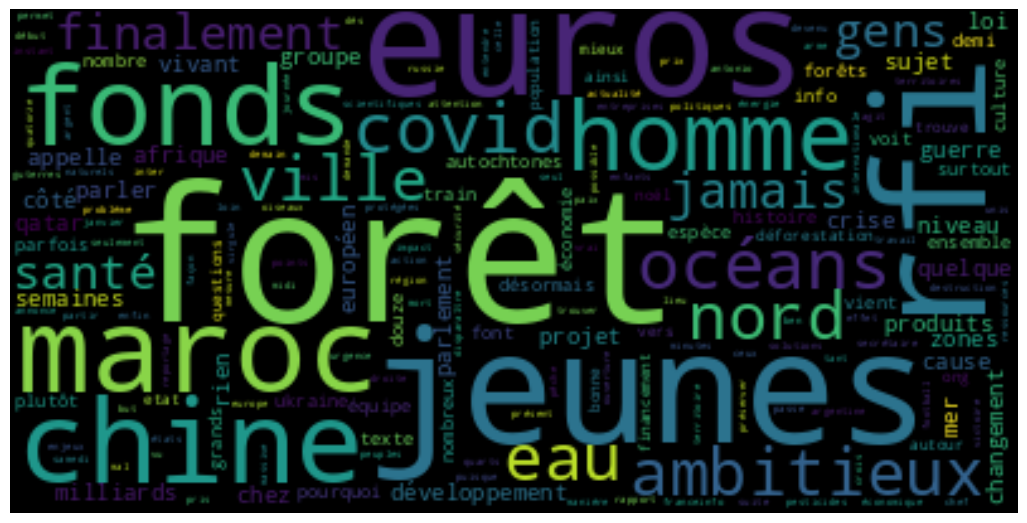

In [71]:
vectorizer = TfidfVectorizer(max_df=0.11, min_df=0.03, stop_words=stopwords)
tfidf_positive_climat_topic = vectorizer.fit_transform(data_top_channel.text)
tfidf_positive_climat_topic_sum = pd.DataFrame(tfidf_positive_climat_topic.T.sum(axis=1), index=vectorizer.get_feature_names_out(), columns=["tfidf_sum"])

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=tfidf_positive_climat_topic_sum.to_dict()['tfidf_sum'])
plt.figure(figsize=(13,8))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [96]:
' '.join([word for word in re.split("\W+",'our nous amener vers un avenir positif pour la nature rfi d') if word not in ['rfi']])

'our nous amener vers un avenir positif pour la nature d'

In [123]:
data_top_channel['text_without_stopwords'].apply(lambda x: 'rfi' in x).sum()

8

In [135]:

words_to_remove = stopwords.copy()
spelt_numbers = ['un', 'deux', 'trois', "quatre", 'cinq', 'six', 'sept', 'huit', 'neuf', 'dix', "vingt", "trente"]
high_freq = ['fait', 'faire', "tout", 'aussi', 'mille', '']
words_to_remove = words_to_remove + TOP_CHANNELS_TV + TOP_CHANNELS_RADIO + ['<unk>', 'euh', "ça", 'rfi', 'unk'] + spelt_numbers + high_freq

pat = r'\b(?:{})\b'.format('|'.join(words_to_remove))

data_top_channel['text_without_stopwords'] = data_top_channel['text'].str.replace(pat, '')


/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_55673/1043154140.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  data_top_channel['text_without_stopwords'] = data_top_channel['text'].str.replace(pat, '')
/var/folders/v6/vd9wd_yd6sq8q9yr7gjwfrfc0000gn/T/ipykernel_55673/1043154140.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_top_channel['text_without_stopwords'] = data_top_channel['text'].str.replace(pat, '')


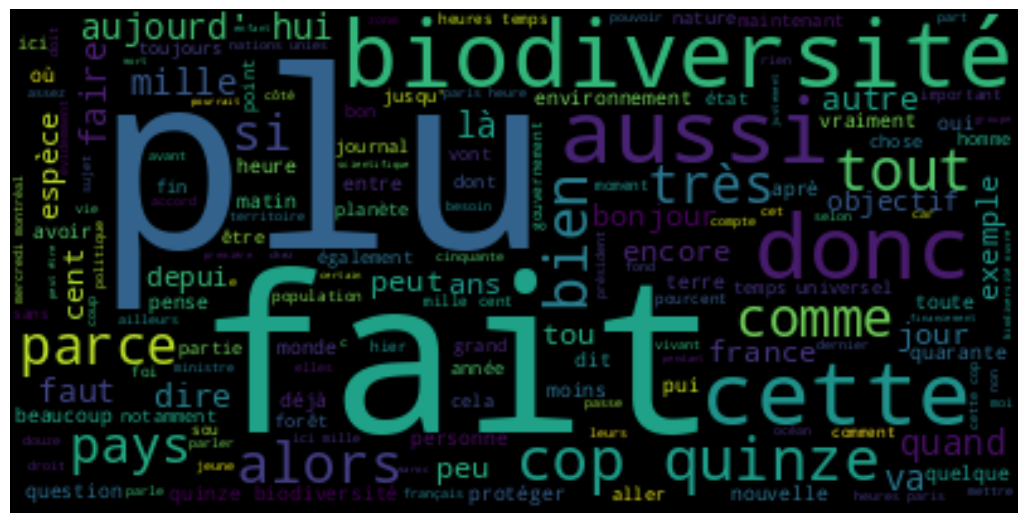

In [136]:
wordcloud = WordCloud().generate(data_top_channel.text_without_stopwords.to_string())
plt.figure(figsize=(13,8))

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Podium TOP and FLOP

In [22]:
show_mentions_by_channel(data[data.radio], n=10,method="minutes", title='Nombre de mention par radio top 10 semaine pre COP27 ')

In [12]:
show_mentions_by_channel(data[~data.radio], n=10,method="minutes", title='Nombre de mention par TV top 10 semaine pre COP27 ')

## En heure de haute audiance

In [19]:
data_tv_1920 = data[(~data.radio)&(data.date.dt.hour >= 19)&(data.date.dt.hour < 21)]
show_mentions_by_channel(data_tv_1920, n=10,method="minutes", title='Nombre de mention par TV entre 19h et 21h top 10 semaine pre COP27')

In [26]:
data_radio_1920 = data[(data.radio)&(data.date.dt.hour >= 6)&(data.date.dt.hour < 10)]
show_mentions_by_channel(data_radio_1920, n=10,method="minutes", title='Nombre de mention par radio entre 6h et 10h top 10 semaine pre COP27')

# Mention au cours du temps

In [21]:
data_top_25_tv = data[data.channel_name.isin(TOP_CHANNELS_TV)]
data_gb = data_top_25_tv.groupby(['channel_name', data_top_25_tv['date'].dt.date]).count()['text'].reset_index()
data_gb.columns = ['Chaîne', 'Date', 'Nombre de mention']
fig = px.area(
    data_gb,
    x = "Date", y = 'Nombre de mention',color = "Chaîne",
    category_orders={"TIME":data_gb["Date"].unique()},
    title = "Evoluation des mentions au cours de la semaine pre COP 27 top 25 TV", height = 400,
)
fig.update_layout( xaxis=dict(type="category", categoryorder='category ascending'),
                     yaxis_title='Nomre de mention COP27 par jour')
fig.show()

In [45]:
data_top_8_tv = data[data.channel_name.isin(TOP_CHANNELS_TV_8)]
data_gb = data_top_8_tv.groupby(['channel_name', data_top_8_tv['date'].dt.date]).count()['text'].reset_index()
data_gb.columns = ['Chaîne', 'Date', 'Nombre de mention']
fig = px.area(
    data_gb,
    x = "Date", y = 'Nombre de mention',color = "Chaîne",
    category_orders={"TIME":data_gb["Date"].unique()},
    title = "Evoluation des mentions au cours de la semaine avant COP 27 top 8 TV", height = 400,
)
fig.update_layout( xaxis=dict(type="category", categoryorder='category ascending'),
                     yaxis_title='Nomre de mention COP27 par jour')
fig.show()

## All

In [24]:
data_radio = data[data.radio]
data_gb = data_radio.groupby(['channel_name', data_radio['date'].dt.date]).count()['text'].reset_index()
data_gb.columns = ['Chaîne', 'Date', 'Nombre de mention']
fig = px.area(
    data_gb,
    x = "Date", y = 'Nombre de mention',color = "Chaîne",
    category_orders={"TIME":data_gb["Date"].unique()},
    title = "Evoluation des mentions au cours de la semaine avant COP 27 toutes radio confondues", height = 400,
)
fig.update_layout( xaxis=dict(type="category", categoryorder='category ascending'),
                     yaxis_title='Nomre de mention COP27 par jour')
fig.show()

In [25]:
show_mentions_by_time_of_the_day(
    data,split = "channel_name",
    list_of_channels = TOP_CHANNELS_TV,kind = "bar",height = 700,method = "minutes"
)

# Couverture mediatique en pourcentage

In [37]:
# TV 18h a day
hours_covered = 18
data_tv_1920 = data[(~data.radio)]
print((data_tv_1920.shape[0] * 2 )/ (data_tv_1920.channel_name.nunique() * 60*hours_covered))
print("Top audimat")

data_tv_1920_top25 = data[(data.channel_name.isin(TOP_25_CHANNELS))]
print((data_tv_1920_top25.shape[0] * 2 )/ (25 *60*hours_covered))

0.019200779727095517
Top audimat
0.018962962962962963


In [33]:
# TV haute audience
data_tv_1920 = data[(~data.radio)&(data.date.dt.hour >= 19)&(data.date.dt.hour < 21)]
print((data_tv_1920.shape[0] * 2 )/ (data_tv_1920.channel_name.nunique() * 120))
print("Top audimat")

data_tv_1920_top25 = data[(data.channel_name.isin(TOP_25_CHANNELS))&(data.date.dt.hour >= 19)&(data.date.dt.hour < 21)]
print((data_tv_1920_top25.shape[0] * 2 )/ (25 * 120))


0.03787878787878788
Top audimat
0.023333333333333334


In [38]:
# radio 18h a day 
hours_covered = 18
data_radio = data[(data.radio)]
print((data_radio.shape[0] * 2 )/ (data_radio.channel_name.nunique() * 60*hours_covered))
print("Top audimat")



0.005680680680680681
Top audimat


In [39]:
# radio haute audiance
hours_covered = 18
data_radio_1920 = data[(data.radio)&(data.date.dt.hour >= 6)&(data.date.dt.hour < 10)]
print((data_radio_1920.shape[0] * 2 )/ (data_radio_1920.channel_name.nunique() * 60*4))
print("Top audimat")

0.014732142857142857
Top audimat


# Theo's work:

# Préparation du Baromètre

## Travail préliminaire sur les données

**Méthodologie** : 
- Sélectionner les heures d'écoute les plus importantes sur TV et Radio
- TV : 19h-22h
- Radio : 6h30-9h30

In [69]:
from quotaclimat.data_analytics.exploration import filter_data_between_hours

In [104]:
data_tv = filter_data_between_hours(data,"19:00","22:00").query("media=='TV'")
data_radio = filter_data_between_hours(data,"06:30","09:30").query("media=='Radio'")
data_france_info = data_radio.query("channel_name=='France Info'")

## Niveau 1

### Calcul du % du temps médiatique

In [105]:
n_days = 16

In [40]:
# Multiplier is 2min / (n_channel * 60min * n_days)
show_mentions_by_time_of_the_day(
    data_tv,freq = "1H",
    method = 2 / (data_tv["channel_name"].nunique() * 60 * n_days)
)

NameError: name 'data_tv' is not defined

In [41]:
# Multiplier is 2min / (n_channel * 60min)
show_mentions_by_time_of_the_day(
    data_radio,freq = "1H",
    method = 2 / (data_radio["channel_name"].nunique() * 60 * n_days)
)

NameError: name 'n_days' is not defined

In [42]:
# Multiplier is 2min / (n_channel * 60min)
show_mentions_by_time_of_the_day(
    data_france_info,freq = "1H",
    method = 2 / (data_france_info["channel_name"].nunique() * 60 * n_days)
)

NameError: name 'data_france_info' is not defined

### Podiums TOP5 et FLOP5

#### TOP 5 et TOP 25 TV (toute audience confondues)

In [122]:
# Multiplier is 2min / (3h * 60min * n_days)
show_mentions_by_channel(
    data_tv,
    method = 2 / (3 * 60 * n_days),
    n = 5,
    text_auto = ".2%"
).update_layout(yaxis_tickformat='0%').show()

# Multiplier is 2min / (3h * 60min * n_days)
show_mentions_by_channel(
    data_tv,
    method = 2 / (3 * 60 * n_days),
    n = 30,
    text_auto = ".2%"
).update_layout(yaxis_tickformat='0%').show()

In [127]:
# Multiplier is 2min / (3h * 60min * n_days)
show_mentions_by_channel(
    data_tv,
    method = 2 / (3 * 60 * n_days),
    list_of_channels = TOP_CHANNELS_TV,
    text_auto = ".1%"
).update_layout(yaxis_tickformat='0%').show()